In [1]:
#select where to run this notebook---
binder_or_localpc=True #True: if you want to run the script using binder or in your local PC
google_colab=False #True: if you want to run the script in google colab

In [2]:
%%capture
#!pip freeze. #to list the packages installed in colab
#or install without checking above (!but do it just once)---
if google_colab:
    !pip install numpy
    !pip install matplotlib
    !pip install netcdf4
    !pip install xarray
    !pip install scipy
    !pip install tqdm

In [3]:
#open packages---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import os
import sys

In [4]:
#modify the local path in case you run this script in your computer---
if binder_or_localpc:
    main_dir="../"
if google_colab:
    #google colab path:
    mount_point='/content/gdrive/' #dir name for a temporal mount point (just for running this script)
    gdrive_path="MyDrive/colab_repos/" #the path in "my Google Drive" where you have cloned the repo
    main_dir=mount_point+gdrive_path
    #mount:
    from google.colab import drive
    drive.mount(mount_point)

In [5]:
#don't modify below names---
#AGU number:
agu_number="num" #put here the agu manuscript number
#name of the repository:
if binder_or_localpc: 
    dir_repo_name=""
if google_colab:
    #name of directories from the cloned github repo:
    dir_repo_name="paper_Atmospherically_Driven_Seasonal_Interannual_LTTS_MultipleInlet/"
dir_data="data/"
dir_functions="functions/"
dir_wavelet_functions="pycwt_wavelet_package/"
dir_figures="figures/"
#name of files with data:
file_Tr_Te="spatially-averaged_15-day-mean_Tr_Te.nc"

In [6]:
#wavelet functions----
#- we are using functions from the package pycwt (https://anaconda.org/conda-forge/pycwt)
#- we have only used some functions of the above package and added our own ones to perform bias correction for the power spectrum (Liu et al., 2007)
#wavelet path:
sys.path.append(f'{main_dir}{dir_repo_name}{dir_functions}{dir_wavelet_functions}')
#functions from pycwt package---
from mothers import Morlet
from helpers import ar1
#our functions---
#inside them we use functions from pycwt
import get_results as gr

In [7]:
#create dir figures if it does not exists---
if not os.path.exists(main_dir+dir_repo_name+dir_figures):
    os.makedirs(main_dir+dir_repo_name+dir_figures)

In [8]:
#set global parameters for figures---
glob_font_size=11
params = {'legend.fontsize':glob_font_size-2,
          'axes.titlesize':glob_font_size,'axes.labelsize': glob_font_size, #size of titles, x-y labels 
          'xtick.labelsize':glob_font_size-1,'ytick.labelsize':glob_font_size-1, #size of xtick-labels, ytick-labels
          'xtick.major.size':2,'xtick.major.width':.8, #length and width of xticks marks
          'ytick.major.size':2,'ytick.major.width':.8,} #length and width of yticks marks
mpl.rcParams.update(params)

In [9]:
#open data---
ds_Tr_Te=xr.open_dataset(main_dir+dir_repo_name+dir_data+file_Tr_Te)

In [10]:
########################################################
def wavelets(data,dim="time",standardization=True,filter_type="low-pass",cutoff_periods=[0.5*365],printing=False,var_label=None):
    """
    - Perform waveles using functions from pycwt package

    Parameters
    ----------
    - data: xr.core.dataarray.DataArray
            Time series of the spatially-averaged 15-day mean "Tr" or "Te", or the 15-day mean "wind energy".
            This is the data used as input for the wavelet function.
    - dim: str
           Dimension used to perform the wavelet. Default="time"
    - standardization: bool
                      True = standardized input data for wavelets.
                      False = use original data for wavelets.
    - filter_type: str
                   Type of wavelet filter to perform. 
                   "low-pass" or "high-pass" or "band-pass".
    - cutoff_periods: list
                      List used to draw cut-off periods of data filter with wavelets.
                      [ref_period] = for low-pass or high-pass filters.
                      [period1, period2] = for band-pass filter.
    - printint: bool
                For printing statistics from the wavelet analysis.
    - var_label: str 
                 String of any random name assigned to the variable employed for wavelet

    Returns
    -------
    - waveler_result: dictionary
                      dictionary with variables related to output of wavelet function.
        freq : array like
            Vector of Fourier frequencies (1 / time units) that
            corresponds to the wavelet scales.
        period : array like
            Vector of Fourier periods (1 / freq).
        scale : numpy.ndarray
            Vector of scale indices given by sj = s0 * 2**(j * dj),
            j={0, 1, ..., J}. 
        wave : numpy.ndarray
            Wavelet transform according to the selected mother wavelet.
            Has (J+1) x N dimensions.
        iwave : numpy.ndarray
            Inverse wavelet transform according to the selected mother wavelet.
            Should be as close as possible to the input data.
        power : numpy.ndarray
            The power spectrum = wave**2
        powerc : numpy.ndarray
            The power spectrum with bias correction (Liu et al., 2007).
        signif : array like
            Significance levels as a function of scale or period (and scaled with variance of signal, =1 for standardized data).
            A regular chi-square test is performed according to Torrence and Compo (1998) equation 18.
        coi : numpy.ndarray
            Returns the cone of influence, which is a vector of N points containing the maximum Fourier period of useful
            information at that particular time. Periods greater than those are subject to edge effects.
        var_exp_wave : float
            variance of the wavelet (Torrence and Compo, 1998, eq. (14)) / variance of the data * 100. 
        rmse_wave : float
            root mean square error between the inverse wavelet and the data 
    - filter_type: str
    - cutoff_periods: list
    
    Notes
    -----
    The parameters employed in the wavelet analysis (see below) are the default ones used by the pycwt package.
    """
    
    #--------------------------------------------    
    #pre proc data
    if "time_dep" in data.dims: data=data.rename({"time_dep":"time"})
    t=data.time.values
    dt=np.diff(t)/np.timedelta64(1,'D')
    dt=dt.mean() #mean time step in days (in case intervals are not exactly the same) 
    data=data.values
    #avg=mean, std=standard deviation, var=variance, and lag=lag-1 correlation coefficient
    avg=data.mean(); std=data.std(); var=std**2
    lag=np.corrcoef(data[:-1],data[1:])[0,1] 
    #standardized data
    if standardization:
        data_stand = (data-avg)/std #(optional to divide with std, but at least remove the mean)
    else:
        data_stand = data-avg
    if printing: print(f'{var_label}: avg={avg:.3f}, std={std:.3f}, var={var:.3f}, lag={lag:.3f}')
    #--------------------------------------------    
           

    #--------------------------------------------
    #Continuous wavelet transform:
    #try to use standardized data (or at least remove the average) when calling cwt_results()
    #- if using standardized data outputs from cwt_results():
    #    * power, inverse wavelet, and power bias corrected are adimensional
    #- without standardization (but with at least average removed):
    #    * power and power bias corrected have units of variance 
    #    * inverse wavelet units of data
    #
    #wavelet parameters------
    #- select the mother wavelet: 
    #    * str ("morlet" with default adimensional frequency f0=6) 
    #    * a class (Morlet with default f0=6, which can be changed, see below)
    #mother=Morlet(); mother._set_f0(f0=5) 
    mother='morlet'    
    #- set the first scale (is equivalent to the lowest fourier period):
    s0=-1 # = 2*dt/mother.flambda()
    #- resolution of the scales:
    dj=1/12  #12 scales between contiguous powers of 2 (this is also the default value employed by pycwt, and seems to be appropiate for our case)
    #dj=1/4  #too low resolution
    #- select the number of scales (without counting the first one):
    J=-1  #It gives all possible scales = log2(len(data) * dt / s0) / dj)
    #J=7/dj  #7 powers of two with dj scales between contiguous powers of 2. Scales will not be complete.
    #- significance level:
    slevel=0.95 
    #---------------------------
    #
    #wavelet power spectrum---
    wavelet_result = gr.cwt_results(data_stand, dt, lag, dj, s0, J, mother, slevel)
    #
    #wavelet filter---
    wavelet_result['data_filter'] = gr.cwt_filter(wavelet_result['period'], wavelet_result['scale'], wavelet_result['wave'], dt, dj, mother, filter_type, cutoff_periods)
    #
    #recover dimensions (do this only when using standardized data as input for wavelets)---
    if standardization:
        wavelet_result['rmse_wave']=wavelet_result['rmse_wave']*std
        wavelet_result['data_filter']=wavelet_result['data_filter']*std+avg #if data was normalized
        wavelet_result['iwave']=wavelet_result['iwave']*std+avg #to be consistent with original signal
        wavelet_result['power']=wavelet_result['power']*var
        wavelet_result['powerc']=wavelet_result['powerc']*var
    if printing: print(f"{var_label}: rmse_wave={wavelet_result['rmse_wave']:.3f}({wavelet_result['rmse_wave']/std*100:.3f}% of std); mse_wave={wavelet_result['rmse_wave']**2:.3f}({wavelet_result['rmse_wave']**2/var*100:.3f}% of var); var explained by wavelet={wavelet_result['var_exp_wave']:.3f}%")
    #--------------------------------------------

    return wavelet_result,filter_type,cutoff_periods

In [11]:
########################################################
def create_cmap(numcolors=11,colores=['blue','white','red'],name='create_cmap'):
    """
    Create a custom diverging colormap
    Default is blue to white to red with 11 colors. Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(N=numcolors,colors=colores,name=name)
    return cmap


########################################################
def cwt_and_wind_based_model_plot(variable,data,wavelet_result,data_levs=None,data_range=None,data_units="",
                                 pow_levs=None,pow_cbar_levs=None,pow_cmap="jet",pow_units="",pow_log2=False,
                                 bias_correct=True,filter_type="low-pass",cutoff_periods=[0.5*365],
                                 glob_font_size=9):
    """
    Plot time series of Tr or Te with the wind energy, and the wavelet spectrum.

    Parameters
    ----------
    - variable: str 
                String with the name of the main variable to plot = "Tr" or "Te".
    - data: xr.core.dataarray.DataArray
            Time series of the spatially-averaged 15-day mean "Tr" or "Te".
            This is the data used as input for wavelet function.
    - waveler_result: list 
                      List with variables related to output of wavelet function.
    - data_levs: list or numpy.ndarray
                 Array or list with yticks for "data" 
    - data_range: list or numpy.ndarray
                 Array or list with y-limits for "data"
    - data_units: str
                  Units for "data". Default no units.
    - pow_levs: list or numpy.ndarray
                Array or list with levels for the contourf of the power spectrum. 
    - pow_cbar_levs: list or numpy.ndarray
                     Array or list with levels for the colorbar of the contourf of the power spectrum.
    - pow_units: str
                 Units of the power spectrum. Default no units.
    - pow_log2: bool
                True (False). Plot wavelet spectrum with (without) log2 scale.
    - bias_correct: bool
                    True (False). Use wavelet outputs with (without) bias correction.
    - filter_type: str
                    Type of wavelet filter to perform. 
                    "low-pass" or "high-pass" or "band-pass".
    - cutoff_periods: list
                      List used to draw cut-off periods of data filter with wavelets.
                      [ref_period] = for low-pass or high-pass filters.
                      [period1, period2] = for band-pass filter.
    Returns
    -------
    - fig: return the figure
                                
    """
    #
    fig,ax=plt.subplots(2,1,figsize=(7.8,5.3),gridspec_kw={'height_ratios':[1.5,3],'hspace':.28},dpi=600)
    #fig,ax=plt.subplots(2,1,figsize=(11,6),gridspec_kw={'height_ratios':[1.3,3.5],'hspace':.3,'wspace':.13},dpi=140)
    ax0=ax[0]; ax1=ax[1]; #ax2=ax[2]
    #
    if "time_dep" in data.dims: dat=dat.rename({"time_dep":"time"})
    time=data.time.values
    #xticks for time 
    xticks_lab=np.arange(int(str(time[0])[:4]),int(str(time[-1])[:4])+4,4)
    xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
    #xticks for period
    yticks =  2. ** np.arange(int(np.log2(wavelet_result['period'][0])),int(np.log2(wavelet_result['period'][-1])+1)) #create the vector of periods
    yticks_lab = [int(i) for i in yticks] # make 2^periods
    #
    if bias_correct:
        power=wavelet_result['powerc']
    else:
        power=wavelet_result['power']
    
    #1)time series with wind model prediction and wind energy----------------
    #plot grey rectangles every 2 years in the background
    tt1=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
    tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
    for i in range(len(tt1)-1): ax0.axvspan(tt1[i],tt2[i],alpha=.6,color='lightgrey') 
    if variable=="Tr":
        data_title=f'Residence time'
        data_label=r"$\hat{T}_r$"
        data_filter_label=r"$\tilde{T}_r$" 
    else:
        data_title=r'Exposure time'
        data_label=r"$\hat{T}_e$"
        data_filter_label=r"$\tilde{T}_e$"
    #
    l0,=ax0.plot(time,data,c='royalblue',lw=.7,label=data_label)
    l1,=ax0.plot(time,wavelet_result['data_filter'],c='r',label=data_filter_label,lw=1.6)
    legend=[l0,l1]
    if type(data_levs)==list or type(data_levs)==np.ndarray:
        ax0.set_yticks(data_levs)
        if type(data_range)==list:
            ax0.set_ylim([data_range[0],data_range[1]])
        else:
            ax0.set_ylim([data_levs[0],data_levs[-1]])          
    else:
        if type(data_range)==list:
            ax0.set_ylim([data_range[0],data_range[1]])    
    ax0.grid(ls=":",lw=.5);ax0.set_ylabel(f"{data_title}\n{data_units}") 
    ax0.set_xlim([np.datetime64('1979-11-01'),xticks[-1]])
    ax0.set_xticks(xticks); ax0.set_xticklabels(xticks_lab,rotation=0);
    ax0.tick_params(direction="in");
    #
    ax0.legend(handles=legend,loc=(0.8,1.03),ncol=4,framealpha=.7,facecolor='lightyellow', borderpad=0.1)
    ax0.set_title('a)',loc='left')
       
    #2)wavelet power spectrum-----------   
    #plot grey rectangles every 2 years in the background
    for i in range(len(tt1)-1): ax1.axvspan(tt1[i],tt2[i],alpha=.6,color='lightgrey',zorder=0)
    if pow_log2:  power=np.log2(power) #log2 scale of power with untis of variance
    if type(pow_levs) is np.ndarray:
        cs=ax1.contourf(time,np.log2(wavelet_result['period']),power,levels=pow_levs,cmap=pow_cmap,zorder=1,extend='max')
    else:
        cs=ax1.contourf(time,np.log2(wavelet_result['period']),power,cmap=pow_cmap,zorder=1,extend='max')        
    for c in cs.collections: c.set_rasterized(True) #fix problems of white lines for pdf format (seems to not work well when testing in Colab)
    #for c in cs.collections: c.set_edgecolor("face") #fix problems of white lines for pdf format (seems to have problems with NaN data)
    ax1.set_ylim([np.log2(wavelet_result['period'][0]),np.log2(wavelet_result['period'][-1])]); ax1.invert_yaxis()
    ax1.set_yticks(np.log2(yticks)); ax1.set_yticklabels(yticks_lab)
    ax1.set_xticks(xticks); ax1.set_xticklabels(xticks_lab);
    #for label in ax1.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
    ax1.set_xlim([np.datetime64('1979-11-01'),xticks[-1]]) 
    cax = fig.add_axes([0.138, 0.168, 0.25, 0.025]) #scale 0-1
    if type(pow_cbar_levs) is np.ndarray:
        cbar=fig.colorbar(cs,cax=cax,orientation='horizontal',ticks=pow_cbar_levs)
    else:
        cbar=fig.colorbar(cs,cax=cax,orientation='horizontal')       
    ax1.text(0.035,0.183,f"{pow_units}",fontsize=glob_font_size,transform=ax1.transAxes)
    cbar.ax.tick_params(labelsize=glob_font_size-2) 
    #
    # 95% significance contour, levels at -99 (fake) and 1 (95% signif)
    ax1.contour(time,np.log2(wavelet_result['period']),wavelet_result['signif'], [-99,1],linewidths=.9, colors='k',zorder=2)
    # cone-of-influence , anything "below" is dubious
    ax1.plot(time,np.log2(wavelet_result['coi']),'k',lw=0.6,zorder=2)
    ax1.fill_between(time,np.log2(wavelet_result['coi']),int(np.log2(wavelet_result['period'][-1])+1), alpha =0.6, hatch = '',zorder=2)
    #cut-off freq lines for any of below cases
    if filter_type in ["low-pass", "high-pass", "band-pass"]:
        ax1.hlines(y=np.log2(cutoff_periods),xmin=time[0],xmax=time[-1],colors='r',ls='--',lw=.8,zorder=3)
    ax1.set_ylabel('Period (days)')
    ax1.set_title('b)',loc='left')
    ax1.tick_params(direction="in"); ax1.grid(linewidth=0.5,ls=':');
    
    return fig

### get wavelet low-pass filtered data (>0.5y)

In [12]:
#for all wavelet plots---
cols=41
#pow_cmap=create_cmap(cols,['floralwhite','yellow','gold','orange','saddlebrown']);pow_cmap.set_under('snow');pow_cmap.set_over('darkred')
pow_cmap="terrain_r"
data_units="(days)"; pow_units="Power (days$^2$)" 
pow_log2=False #False = contourf without log2 scale 
bias_correct=True #True = plot wavelet transform with bias correction

### Residence time Tr

In [13]:
#wavelet--
variable="Tr"
wavelet_Tr,filter_type,cutoff_periods = wavelets(data=ds_Tr_Te.Tr_hat,var_label=variable,printing=True)

Tr: avg=13.654, std=3.800, var=14.437, lag=0.737
Tr: rmse_wave=0.251(6.611% of std); mse_wave=0.063(0.437% of var); var explained by wavelet=96.900%


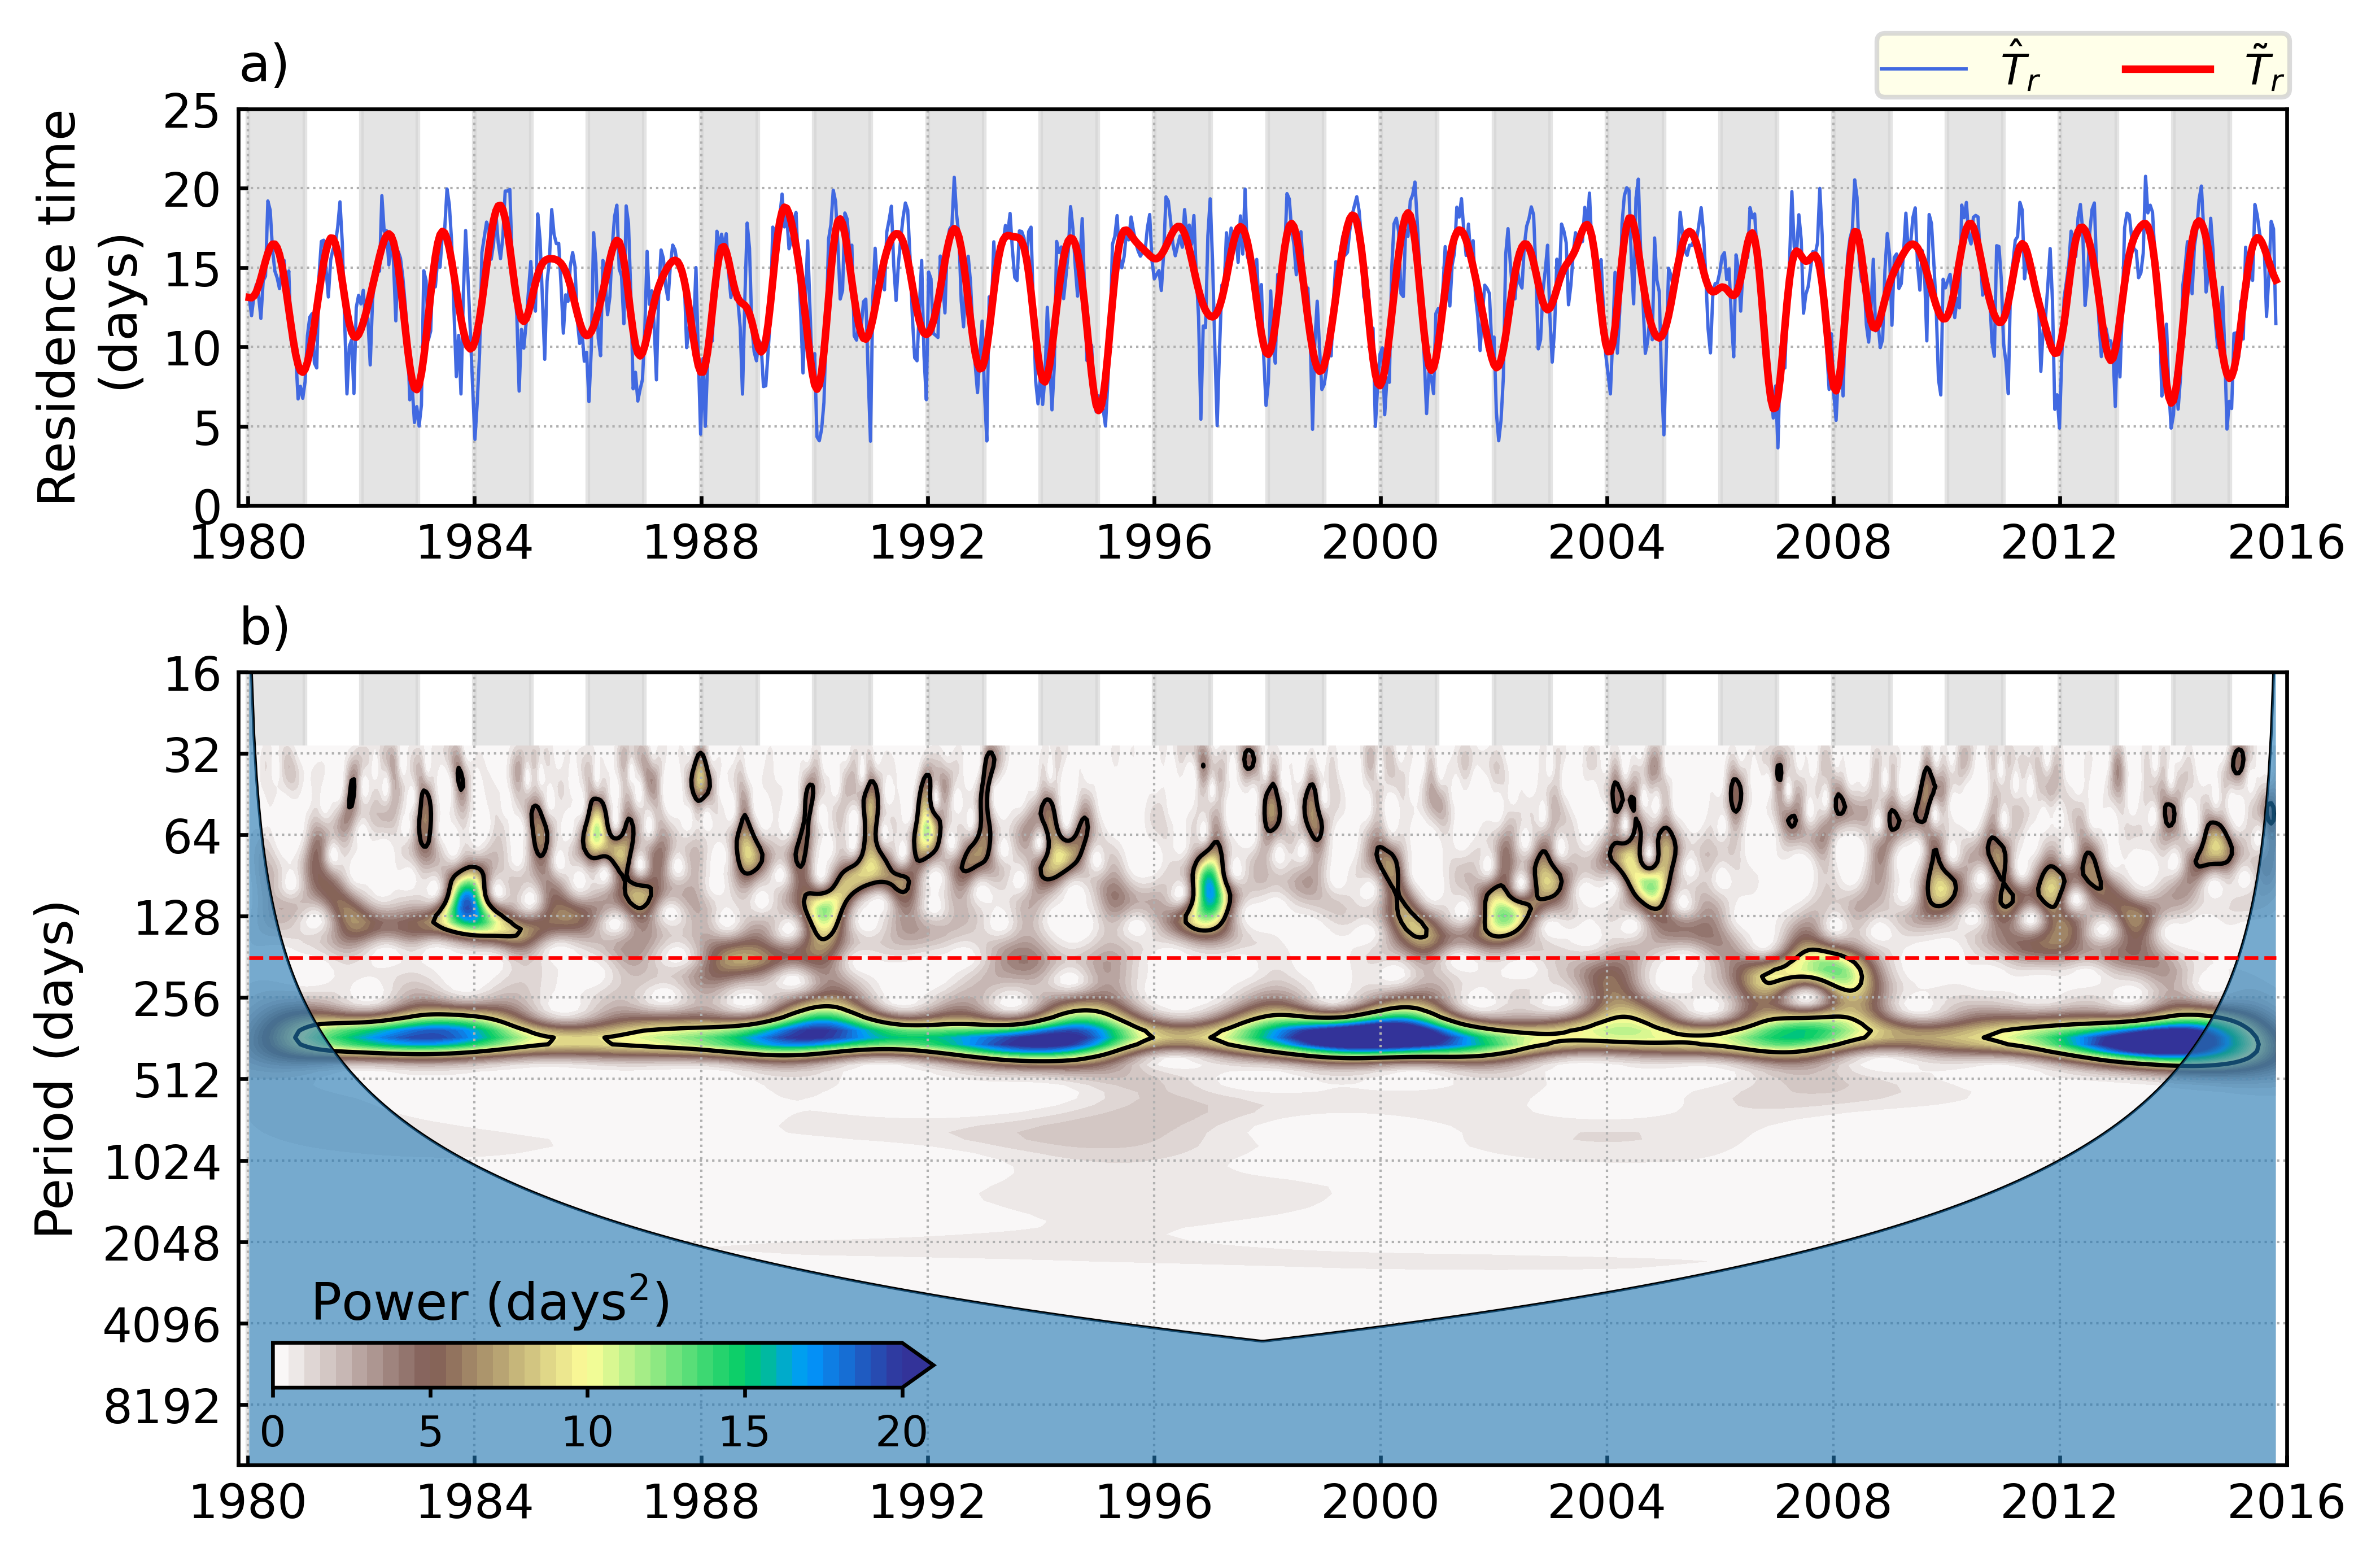

In [14]:
#plot using wind based model, which used 15-day lag for predictor---
data_levs=np.arange(0,26,5); data_range=None #yticks and ylim for data (days)
pow_levs=np.linspace(0,20,cols); pow_cbar_levs=np.arange(0,pow_levs[-1]+1,5)
#
fig=cwt_and_wind_based_model_plot(variable,ds_Tr_Te.Tr_hat,wavelet_Tr,data_levs,data_range,data_units,
                                  pow_levs,pow_cbar_levs,pow_cmap,pow_units,pow_log2,
                                  bias_correct,filter_type,cutoff_periods,
                                  glob_font_size)
fig_name='f04'
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)
#fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.pdf',bbox_inches='tight',pad_inches=0.1,dpi=600)

### Exposure time Te

In [15]:
#wavelet--
variable="Te"
wavelet_Te,filter_type,cutoff_periods = wavelets(data=ds_Tr_Te.Te_hat,var_label=variable,printing=True)

Te: avg=18.964, std=6.027, var=36.329, lag=0.776
Te: rmse_wave=0.306(5.084% of std); mse_wave=0.094(0.259% of var); var explained by wavelet=97.300%


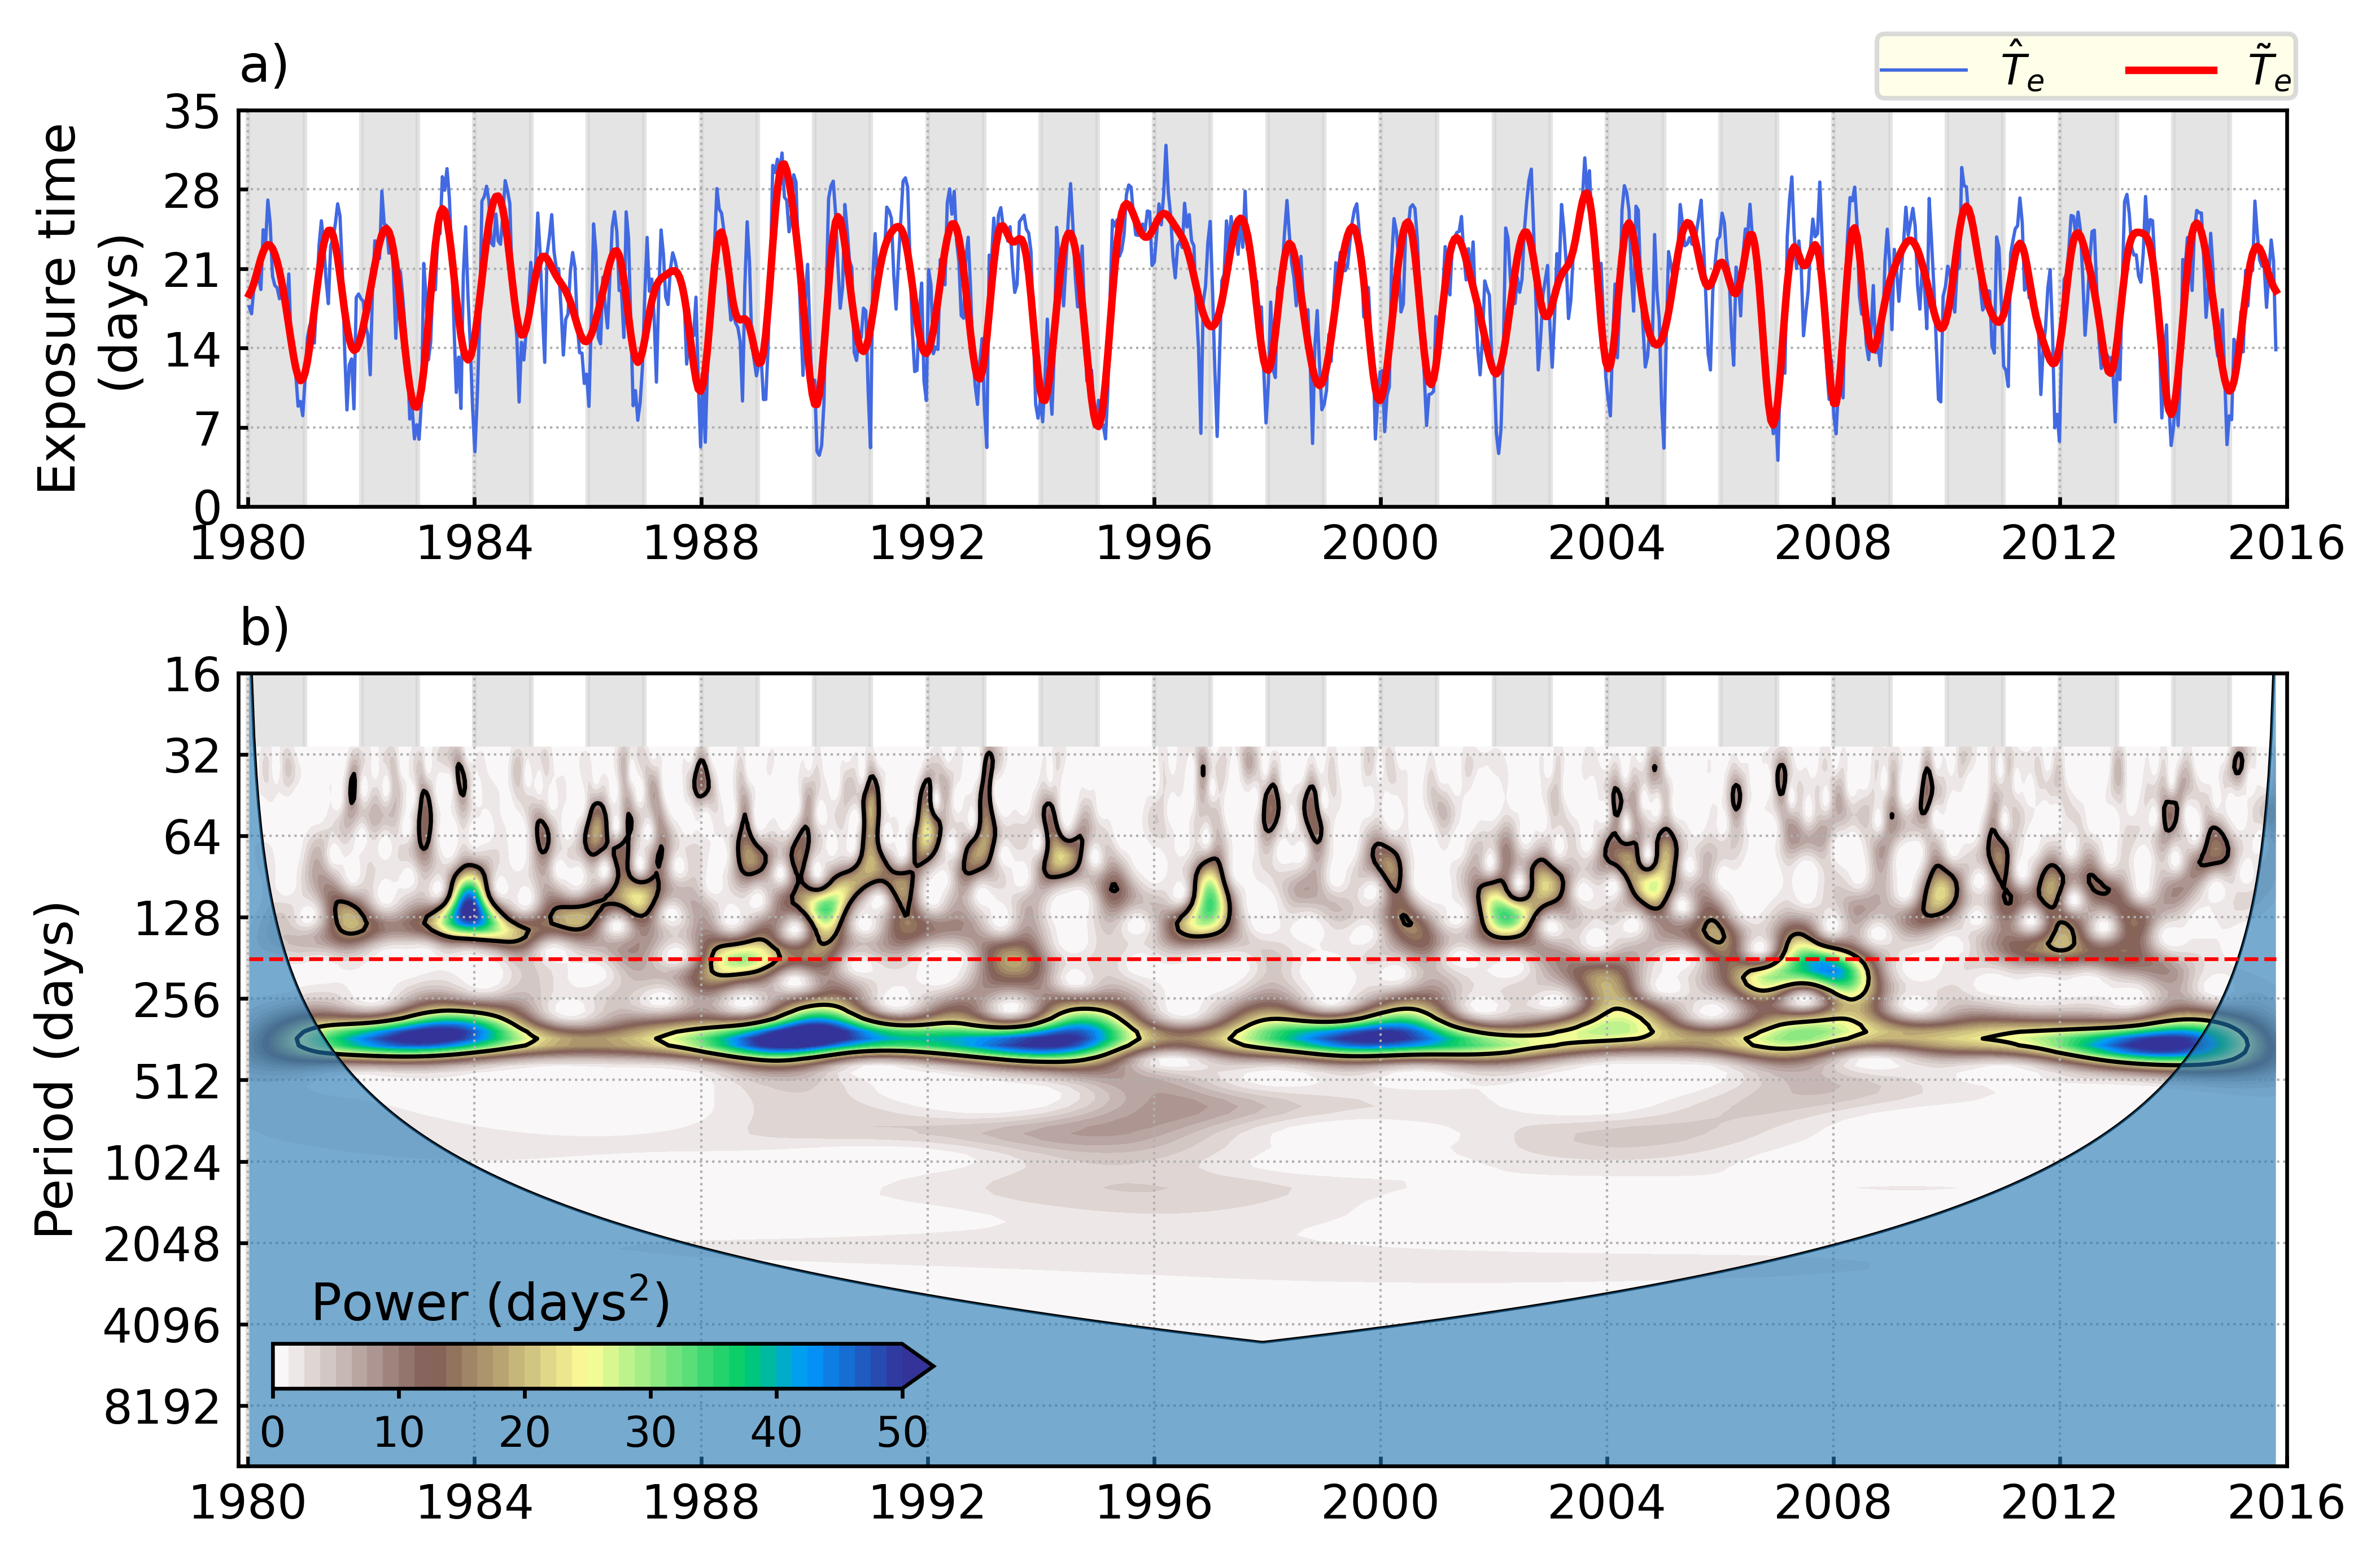

In [16]:
#plot using wind based model, which used 15-day lag for predictor---
data_levs=np.arange(0,36,7); data_range=None #yticks and ylim for data (days)
pow_levs=np.linspace(0,50,cols); pow_cbar_levs=np.arange(0,pow_levs[-1]+1,10)
#
fig=cwt_and_wind_based_model_plot(variable,ds_Tr_Te.Te_hat,wavelet_Te,data_levs,data_range,data_units,
                                  pow_levs,pow_cbar_levs,pow_cmap,pow_units,pow_log2,
                                  bias_correct,filter_type,cutoff_periods,
                                  glob_font_size)
fig_name='f05'
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)
#fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.pdf',bbox_inches='tight',pad_inches=0.1,dpi=600)

In [17]:
# ##check possible mistake from original pycwt package in the function significance from wavelet.py when N=!1----

# def pk_original(k, a, N):
#     return (1 - a ** 2) / (1 + a ** 2 - 2 * a * np.cos(2 * np.pi * k / N))
# def pk_new(k, a):
#     return (1 - a ** 2) / (1 + a ** 2 - 2 * a * np.cos(2 * np.pi * k)) 
#     #return (1 - a ** 2) / (np.abs(1 - a * np.exp(-2 * np.pi * 1j * k)))**2 #the same as above
# tt=ds_Tr_Te.Tr_hat.time.values
# dt=np.diff(tt)/np.timedelta64(1,'D')
# dt=dt.mean() #mean time step in days (in case intervals are not exactly the same) 
# mother=Morlet(); 
# period = wavelet_Tr['scale'] * mother.flambda()  # Fourier equivalent periods
# freq = dt / period                   # Normalized frequency (from ~0 to 0.5 as the first period is 2*dt)
# lag1=0.74
# fft_theor1 = pk_original(freq, lag1, len(ds_Tr_Te.Tr_hat.time))
# fft_theor2 = pk_new(freq, lag1) #freq=Normalized frequency

# plt.plot(fft_theor1,'r')
# plt.plot(fft_theor2,'b')